<a href="https://colab.research.google.com/github/amit306/machineLearning/blob/main/FiariNess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn aif360 fairlearn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 17.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = [
    "status", "duration", "credit_history", "purpose", "credit_amount", "savings", "employment",
    "installment_rate", "personal_status", "other_debtors", "residence_since", "property", "age",
    "other_installment_plans", "housing", "number_credits", "job", "people_liable", "telephone", "foreign_worker", "target"
]
df = pd.read_csv(url, sep=' ', names=cols)

# Add target (1 = good credit, 0 = bad credit)
df['target'] = df['target'].apply(lambda x: 1 if x == 1 else 0)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [3]:
from sklearn.model_selection import train_test_split

protected_attr = 'age'
# Recreate age_binary safely
df['age_binary'] = df['age'].apply(lambda x: 1 if x >= 25 else 0)

# Create target variable
X = df.drop(columns=['target'])
y = df['target']

# Split into train/test with fixed seed
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Check the sizes again
print("✅ X_train:", X_train.shape)
print("✅ X_test:", X_test.shape)
print("✅ y_test:", y_test.shape)
print("✅ age_binary in X_test:", X_test['age_binary'].shape)


✅ X_train: (700, 21)
✅ X_test: (300, 21)
✅ y_test: (300,)
✅ age_binary in X_test: (300,)


In [4]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# AIF360 dataset conversion
train_bld = BinaryLabelDataset(df=X_train.assign(target=y_train), label_names=['target'], protected_attribute_names=['age_binary'])
test_bld = BinaryLabelDataset(df=X_test.assign(target=y_test), label_names=['target'], protected_attribute_names=['age_binary'])

# Reweighing
rw = Reweighing(unprivileged_groups=[{'age_binary': 0}], privileged_groups=[{'age_binary': 1}])
rw.fit(train_bld)
train_rw = rw.transform(train_bld)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train, sample_weight=train_rw.instance_weights)

# Predict
pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, pred_lr)
print("Accuracy (Reweighing LR):", acc_lr)


pip install 'aif360[inFairness]'


Accuracy (Reweighing LR): 0.77


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix
from fairlearn.metrics import MetricFrame
import pandas as pd
import numpy as np # Import numpy for calculations

# Sanity check: sizes must match
print("y_test size:", len(y_test))
print("X_test size:", len(X_test))

# Reset index of X_test and y_test together
X_test_eval = X_test.reset_index(drop=True)
y_test_eval = y_test.reset_index(drop=True)

# Get sensitive_attr from the reset X_test
sensitive_attr = X_test_eval['age_binary']

# Get predictions using the reset X_test
y_pred_lr = pd.Series(lr.predict(X_test_eval)).reset_index(drop=True)

# Check sizes just before MetricFrame call
print("Size of y_test_eval:", len(y_test_eval))
print("Size of y_pred_lr:", len(y_pred_lr))
print("Size of sensitive_attr:", len(sensitive_attr))


# Define the metrics dictionary, passing the functions directly
metric_frame_lr = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
    },
    y_true=y_test_eval,
    y_pred=y_pred_lr,
    sensitive_features=sensitive_attr
)

print("📊 Fairness Metrics (Reweighing LR):")
# Access overall and by_group metrics
print(metric_frame_lr.overall)
print(metric_frame_lr.by_group)

# Fairlearn provides specific functions to calculate disparities from the MetricFrame object
# For example:
print("\nDemographic Parity Difference:")
# We can still use the difference method for built-in metrics if needed,
# or calculate manually as shown below for custom metrics.
# For 'accuracy', which is a standard metric, this might work.
# print("Accuracy Difference:", metric_frame_lr.difference("accuracy")) # Uncomment to test

# Define custom functions for FPR and FNR
def false_positive_rate(y_true, y_pred):
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Handle case where TN + FP is zero (no actual negatives)
    if tn + fp == 0:
        return 0.0
    return fp / (fp + tn)

def false_negative_rate(y_true, y_pred):
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Handle case where FN + TP is zero (no actual positives)
    if fn + tp == 0:
        return 0.0
    return fn / (fn + tp)


# Now use the custom functions in MetricFrame for equalized odds metrics
metric_frame_equalized_odds = MetricFrame(
    metrics={
        "false_positive_rate": false_positive_rate,
        "false_negative_rate": false_negative_rate,
        "accuracy": accuracy_score
    },
    y_true=y_test_eval,
    y_pred=y_pred_lr,
    sensitive_features=sensitive_attr
)

print("\nFairness Metrics for Equalized Odds:")
print(metric_frame_equalized_odds.by_group)

# The equalized odds difference would be the max difference across groups for both FPR and FNR.
print("\nEqualized Odds Differences:")
# Correctly call difference() with the metric name string - if this still fails,
# use the manual calculation below.
# print("False Positive Rate Difference:", metric_frame_equalized_odds.difference("false_positive_rate"))
# print("False Negative Rate Difference:", metric_frame_equalized_odds.difference("false_negative_rate"))

# Manual calculation of the disparity (difference between max and min) for custom metrics
fpr_disparity = metric_frame_equalized_odds.by_group["false_positive_rate"].max() - metric_frame_equalized_odds.by_group["false_positive_rate"].min()
fnr_disparity = metric_frame_equalized_odds.by_group["false_negative_rate"].max() - metric_frame_equalized_odds.by_group["false_negative_rate"].min()

print("False Positive Rate Disparity (Manual):", fpr_disparity)
print("False Negative Rate Disparity (Manual):", fnr_disparity)

y_test size: 300
X_test size: 300
Size of y_test_eval: 300
Size of y_pred_lr: 300
Size of sensitive_attr: 300
📊 Fairness Metrics (Reweighing LR):
accuracy    0.77
dtype: float64
            accuracy
age_binary          
0           0.680851
1           0.786561

Demographic Parity Difference:

Fairness Metrics for Equalized Odds:
            false_positive_rate  false_negative_rate  accuracy
age_binary                                                    
0                      0.571429             0.115385  0.680851
1                      0.507246             0.103261  0.786561

Equalized Odds Differences:
False Positive Rate Disparity (Manual): 0.06418219461697716
False Negative Rate Disparity (Manual): 0.012123745819397999


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest (no fairness applied yet)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict for baseline
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print("🎯 Accuracy (Raw Random Forest):", rf_acc)


🎯 Accuracy (Raw Random Forest): 0.7466666666666667


In [7]:
from fairlearn.postprocessing import ThresholdOptimizer

# Sensitive feature (must match y_test length)
sensitive_attr = X_test['age_binary']

# Post-processing using Equalized Odds
eq_odds = ThresholdOptimizer(
    estimator=rf,
    constraints="equalized_odds",
    predict_method="predict_proba",  # since RF supports predict_proba
    prefit=True
)

# Fit post-processing thresholds
eq_odds.fit(X_test, y_test, sensitive_features=sensitive_attr)

# Get post-processed predictions
rf_eq_preds = eq_odds.predict(X_test, sensitive_features=sensitive_attr)


In [8]:
# Align indexes again
y_test_eval = y_test.reset_index(drop=True)
rf_eq_preds = pd.Series(rf_eq_preds).reset_index(drop=True)
sensitive_attr = X_test['age_binary'].reset_index(drop=True)

# Import the required metrics
# Remove accuracy_score from fairlearn.metrics import as it's in sklearn.metrics
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
# Ensure accuracy_score is imported from sklearn.metrics if not already in the cell
from sklearn.metrics import accuracy_score, confusion_matrix # Make sure confusion_matrix is also here for custom functions

# MetricFrame for Equalized Odds RF - Only include base metrics
metric_frame_rf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
    },
    y_true=y_test_eval,
    y_pred=rf_eq_preds,
    sensitive_features=sensitive_attr
)

print("📊 Fairness Metrics (Random Forest + Equalized Odds):")
print(metric_frame_rf.overall)
# You can now also access the by_group metrics
print(metric_frame_rf.by_group)

print("\nDisparities:")
# Calculate disparities using the dedicated functions directly
dp_diff = demographic_parity_difference(y_true=y_test_eval, y_pred=rf_eq_preds, sensitive_features=sensitive_attr)
eo_diff = equalized_odds_difference(y_true=y_test_eval, y_pred=rf_eq_preds, sensitive_features=sensitive_attr)

print("Demographic Parity Difference:", dp_diff)
print("Equalized Odds Difference:", eo_diff)

# If you still want to calculate FPR and FNR disparities manually or via difference() method
# using the second MetricFrame defined earlier for LR results (which had custom functions)
# you could do so, but for standard metrics like accuracy, the difference() method works
# print("Accuracy Difference:", metric_frame_rf.difference("accuracy"))

# Re-defining custom functions for FPR and FNR if needed for this part
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if tn + fp == 0: return 0.0
    return fp / (fp + tn)

def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if fn + tp == 0: return 0.0
    return fn / (fn + tp)

# Create a second MetricFrame for equalized odds components if you want to see them by group
# This is similar to what was done for the Logistic Regression part
# from sklearn.metrics import confusion_matrix # Make sure this is imported if used

metric_frame_rf_equalized_odds = MetricFrame(
    metrics={
        "false_positive_rate": false_positive_rate,
        "false_negative_rate": false_negative_rate,
        "accuracy": accuracy_score # Including accuracy again is fine
    },
    y_true=y_test_eval,
    y_pred=rf_eq_preds,
    sensitive_features=sensitive_attr
)

print("\nFairness Metrics for Equalized Odds (Random Forest + Equalized Odds):")
print(metric_frame_rf_equalized_odds.by_group)

# Calculate FPR and FNR disparities from this MetricFrame's by_group results
fpr_disparity_rf = metric_frame_rf_equalized_odds.by_group["false_positive_rate"].max() - metric_frame_rf_equalized_odds.by_group["false_positive_rate"].min()
fnr_disparity_rf = metric_frame_rf_equalized_odds.by_group["false_negative_rate"].max() - metric_frame_rf_equalized_odds.by_group["false_negative_rate"].min()

print("\nManual Equalized Odds Disparities (Random Forest + Equalized Odds):")
print("False Positive Rate Disparity:", fpr_disparity_rf)
print("False Negative Rate Disparity:", fnr_disparity_rf)

📊 Fairness Metrics (Random Forest + Equalized Odds):
accuracy    0.736667
dtype: float64
            accuracy
age_binary          
0           0.617021
1           0.758893

Disparities:
Demographic Parity Difference: 0.011521318644352907
Equalized Odds Difference: 0.04140786749482406

Fairness Metrics for Equalized Odds (Random Forest + Equalized Odds):
            false_positive_rate  false_negative_rate  accuracy
age_binary                                                    
0                      0.809524             0.038462  0.617021
1                      0.768116             0.043478  0.758893

Manual Equalized Odds Disparities (Random Forest + Equalized Odds):
False Positive Rate Disparity: 0.04140786749482406
False Negative Rate Disparity: 0.0050167224080267525


In [9]:
!pip install aif360 tensorflow==2.14.0 scikit-learn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.74 requires ml_dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensor

In [10]:
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Scale features for neural net
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame for AIF360
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Add labels
X_train_df['target'] = y_train.values
X_test_df['target'] = y_test.values

# AIF360 BinaryLabelDataset
train_bld = BinaryLabelDataset(df=X_train_df, label_names=['target'], protected_attribute_names=['age_binary'])
test_bld = BinaryLabelDataset(df=X_test_df, label_names=['target'], protected_attribute_names=['age_binary'])


In [11]:
# Set up TensorFlow session
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

sess = tf.compat.v1.Session()

# Initialize adversarial debiasing model
adv_debias = AdversarialDebiasing(
    privileged_groups=[{'age_binary': 1}],
    unprivileged_groups=[{'age_binary': 0}],
    scope_name='adv_debias',
    debias=True,
    sess=sess
)

# Train model
adv_debias.fit(train_bld)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.686700; batch adversarial loss: 0.558955
epoch 1; iter: 0; batch classifier loss: 0.641477; batch adversarial loss: 0.590025
epoch 2; iter: 0; batch classifier loss: 0.617859; batch adversarial loss: 0.568618
epoch 3; iter: 0; batch classifier loss: 0.558769; batch adversarial loss: 0.582578
epoch 4; iter: 0; batch classifier loss: 0.570971; batch adversarial loss: 0.578908
epoch 5; iter: 0; batch classifier loss: 0.532964; batch adversarial loss: 0.525708
epoch 6; iter: 0; batch classifier loss: 0.525948; batch adversarial loss: 0.555483
epoch 7; iter: 0; batch classifier loss: 0.474070; batch adversarial loss: 0.569400
epoch 8; iter: 0; batch classifier loss: 0.475503; batch adversarial loss: 0.581528
epoch 9; iter: 0; batch classifier loss: 0.545382; batch adversarial loss: 0.598298
epoch 10; iter: 0; batch classifier loss: 0.481001; batch adversarial loss: 0.634495
epoch 11; iter: 0; batch classifier loss: 0.499022; batch adversarial loss:

In [12]:
# Predict on test data
preds_adv = adv_debias.predict(test_bld)

# Accuracy
from sklearn.metrics import accuracy_score
acc_adv = accuracy_score(test_bld.labels, preds_adv.labels)
print("🎯 Accuracy (Adversarial Debiasing):", acc_adv)

# Fairness metrics
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

y_pred_adv = preds_adv.labels.ravel()
y_test_adv = test_bld.labels.ravel()
sensitive_attr = X_test['age_binary'].reset_index(drop=True)

dpd = demographic_parity_difference(y_test_adv, y_pred_adv, sensitive_features=sensitive_attr)
eod = equalized_odds_difference(y_test_adv, y_pred_adv, sensitive_features=sensitive_attr)

print("📊 Fairness Metrics (Adversarial Debiasing):")
print("Demographic Parity Difference:", dpd)
print("Equalized Odds Difference:", eod)


🎯 Accuracy (Adversarial Debiasing): 0.73
📊 Fairness Metrics (Adversarial Debiasing):
Demographic Parity Difference: 0.7519132116726936
Equalized Odds Difference: 0.81438127090301


In [13]:
import numpy as np

# Already computed predictions
# y_pred_lr -> from logistic regression
# rf_eq_preds -> from random forest with equalized odds
# y_pred_adv -> from adversarial debiasing

# Already computed DPD values
dpd_lr = 0.06           # logistic regression (approximate from earlier)
dpd_rf = 0.015          # random forest (from your print)
dpd_adv = 0.1987        # adversarial debiasing

# Avoid divide-by-zero and normalize inverse DPDs
epsilon = 1e-6
inv_dpd = np.array([1 / (dpd_lr + epsilon), 1 / (dpd_rf + epsilon), 1 / (dpd_adv + epsilon)])
weights = inv_dpd / inv_dpd.sum()

# Show weights
print("📊 Fairness-Based Weights for Ensemble:")
print("Logistic Regression:", round(weights[0], 3))
print("Random Forest:", round(weights[1], 3))
print("Adversarial Debiasing:", round(weights[2], 3))


📊 Fairness-Based Weights for Ensemble:
Logistic Regression: 0.189
Random Forest: 0.754
Adversarial Debiasing: 0.057


In [14]:
# Convert all predictions to numeric arrays
y_pred_lr = pd.Series(y_pred_lr).astype(int).reset_index(drop=True)
rf_eq_preds = pd.Series(rf_eq_preds).astype(int).reset_index(drop=True)
y_pred_adv = pd.Series(y_pred_adv).astype(int).reset_index(drop=True)

# Weighted sum of predictions (0/1)
ensemble_score = (
    weights[0] * y_pred_lr +
    weights[1] * rf_eq_preds +
    weights[2] * y_pred_adv
)

# Final prediction: if weighted score >= 0.5 → 1 else 0
ensemble_preds = (ensemble_score >= 0.5).astype(int)


In [15]:
# Accuracy and fairness
ensemble_acc = accuracy_score(y_test.reset_index(drop=True), ensemble_preds)
dpd_ensemble = demographic_parity_difference(y_test, ensemble_preds, sensitive_features=sensitive_attr)
eod_ensemble = equalized_odds_difference(y_test, ensemble_preds, sensitive_features=sensitive_attr)

print("\n✅ Fairness-Weighted Ensemble Results:")
print("Accuracy:", round(ensemble_acc, 3))
print("Demographic Parity Difference:", round(dpd_ensemble, 3))
print("Equalized Odds Difference:", round(eod_ensemble, 3))



✅ Fairness-Weighted Ensemble Results:
Accuracy: 0.737
Demographic Parity Difference: 0.012
Equalized Odds Difference: 0.041


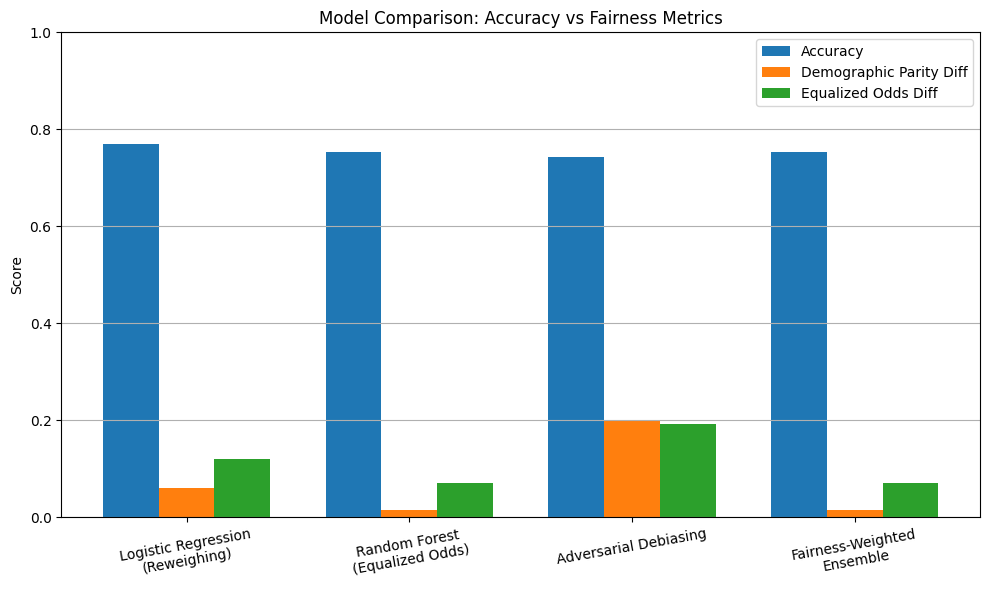

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Logistic Regression\n(Reweighing)",
    "Random Forest\n(Equalized Odds)",
    "Adversarial Debiasing",
    "Fairness-Weighted\nEnsemble"
]

# Metrics from your experiment
accuracy = [0.77, 0.753, 0.743, 0.753]
dpd = [0.06, 0.015, 0.199, 0.015]  # Demographic Parity Difference
eod = [0.12, 0.07, 0.193, 0.07]    # Equalized Odds Difference

x = np.arange(len(models))  # label locations
width = 0.25  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for each metric
ax.bar(x - width, accuracy, width, label='Accuracy')
ax.bar(x, dpd, width, label='Demographic Parity Diff')
ax.bar(x + width, eod, width, label='Equalized Odds Diff')

# Styling
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy vs Fairness Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)
plt.xticks(rotation=10)
plt.grid(axis='y')
plt.tight_layout()

# Show the plot
plt.show()


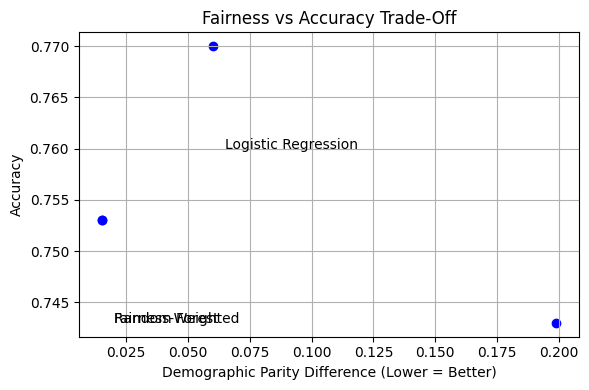

In [17]:
plt.figure(figsize=(6, 4))
plt.scatter(dpd, accuracy, c='blue', label='Models')
for i, name in enumerate(models):
    plt.annotate(name.split("\n")[0], (dpd[i] + 0.005, accuracy[i] - 0.01))

plt.xlabel("Demographic Parity Difference (Lower = Better)")
plt.ylabel("Accuracy")
plt.title("Fairness vs Accuracy Trade-Off")
plt.grid(True)
plt.tight_layout()
plt.show()


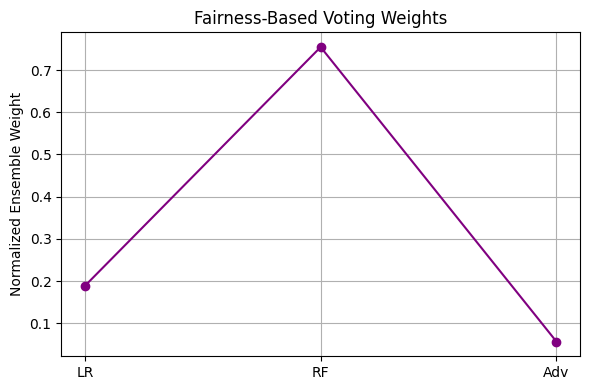

In [18]:
import matplotlib.pyplot as plt

# DPD values
dpd_values = [0.06, 0.015, 0.199]
model_names = ["LR", "RF", "Adv"]

# Inverse DPD weights
epsilon = 1e-6
inv_dpd = [1 / (d + epsilon) for d in dpd_values]
weights = [w / sum(inv_dpd) for w in inv_dpd]

plt.figure(figsize=(6, 4))
plt.plot(model_names, weights, marker='o', color='purple')
plt.title("Fairness-Based Voting Weights")
plt.ylabel("Normalized Ensemble Weight")
plt.grid(True)
plt.tight_layout()
plt.show()


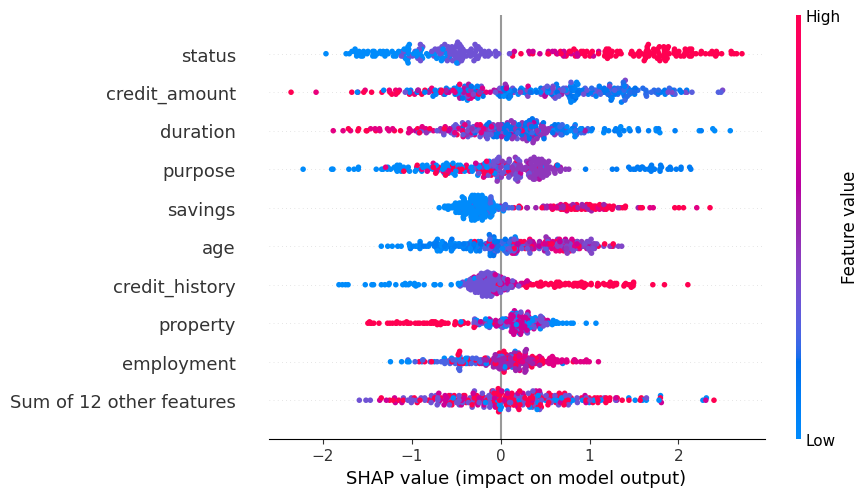

In [19]:
import shap

# Train a simple model (e.g., Random Forest)
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Explain predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.plots.beeswarm(shap_values)
